# MOT coil calculations.

Santi

10 February 2026


The goal here is to calculate the number of turns necessary to achieve various B-field values for the RbCs experiment. We want to put the MOT coils around the source chamber, which is the Kimball physics 6" octagon.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import magpylib as magpy

# -------------------- Unit conversions --------------------
T_TO_G = 1e4          # Tesla -> Gauss
T_PER_M_TO_G_PER_CM = 100.0  # (T/m) -> (G/cm)
M_TO_CM = 100.0

# -------------------- Build thick coil as many Circle loops --------------------
def make_thick_coil(
    radius, radial_thickness, axial_thickness,
    z_center, Nturns, I_per_turn,
    Nr=8, Nz=8,
):
    """
    Returns a magpylib Collection representing a finite-thickness coil.

    Inputs in SI:
      radius, radial_thickness, axial_thickness, z_center in meters
      Nturns: total turns
      I_per_turn: current per turn in Amps (sign sets direction)
    """
    r_vals = np.linspace(radius - radial_thickness/2, radius + radial_thickness/2, Nr)
    z_vals = np.linspace(z_center - axial_thickness/2, z_center + axial_thickness/2, Nz)

    loops = []
    turns_per_loop = Nturns / (Nr * Nz)

    for r in r_vals:
        for z0 in z_vals:
            loop = magpy.current.Circle(
                current=I_per_turn * turns_per_loop,
                diameter=2*r,
                position=(0, 0, z0),
            )
            loops.append(loop)

    return magpy.Collection(*loops)

def make_two_coils(
    radius, radial_thickness, axial_thickness, sep,
    Nturns, I1_per_turn, I2_per_turn,
    Nr=8, Nz=8
):
    """
    Build two coils centered at z=+sep/2 and z=-sep/2 with independent currents.
    """
    coil1 = make_thick_coil(
        radius, radial_thickness, axial_thickness,
        z_center=+sep/2,
        Nturns=Nturns, I_per_turn=I1_per_turn,
        Nr=Nr, Nz=Nz
    )
    coil2 = make_thick_coil(
        radius, radial_thickness, axial_thickness,
        z_center=-sep/2,
        Nturns=Nturns, I_per_turn=I2_per_turn,
        Nr=Nr, Nz=Nz
    )
    return coil1 + coil2

# -------------------- Field sampling along axes --------------------
def compute_axis_fields(sources, xmax=0.02, ymax=0.02, zmax=0.02, npts=801):
    """
    Compute:
      Bx(x) along x-axis (y=z=0)
      By(y) along y-axis (x=z=0)
      Bz(z) along z-axis (x=y=0)
    using magpylib.getB in Tesla.
    """
    x = np.linspace(-xmax, xmax, npts)
    y = np.linspace(-ymax, ymax, npts)
    z = np.linspace(-zmax, zmax, npts)

    obs_x = np.column_stack([x, np.zeros_like(x), np.zeros_like(x)])
    obs_y = np.column_stack([np.zeros_like(y), y, np.zeros_like(y)])
    obs_z = np.column_stack([np.zeros_like(z), np.zeros_like(z), z])

    Bx_vec = magpy.getB(sources, obs_x)  # shape (npts,3), Tesla
    By_vec = magpy.getB(sources, obs_y)
    Bz_vec = magpy.getB(sources, obs_z)

    Bx_x = Bx_vec[:, 0]
    By_y = By_vec[:, 1]
    Bz_z = Bz_vec[:, 2]

    return (x, Bx_x), (y, By_y), (z, Bz_z)

# -------------------- 3D plot with current arrows --------------------
def plot_geometry_3d(sources, radius, sep, I1_per_turn, I2_per_turn):
    """
    Uses magpylib.show() to display geometry and adds two arrows with matplotlib
    to indicate current direction on each coil.
    """
    fig = magpy.show(sources, backend="matplotlib")  # returns matplotlib figure
    # ax = fig.axes[0]

    # Arrow locations (in meters)
    # Put arrows near +x on each coil at z=±sep/2, tangent direction ±y depending on current sign
    x0 = radius
    y0 = 0.0

    def add_arrow(z0, I, color):
        sign = np.sign(I) if I != 0 else 1.0
        # tangent at (x=R, y=0) is +y for CCW (sign=+), -y for CW (sign=-)
        dx, dy, dz = 0.0, sign * (0.3 * radius), 0.0  # arrow length ~0.3R
        # ax.quiver(x0, y0, z0, dx, dy, dz, color=color, linewidth=2)

    add_arrow(+sep/2, I1_per_turn, "C1")
    add_arrow(-sep/2, I2_per_turn, "C2")

    # ax.set_title("MOT coil geometry (Magpylib) with current-direction arrows")
    plt.show()




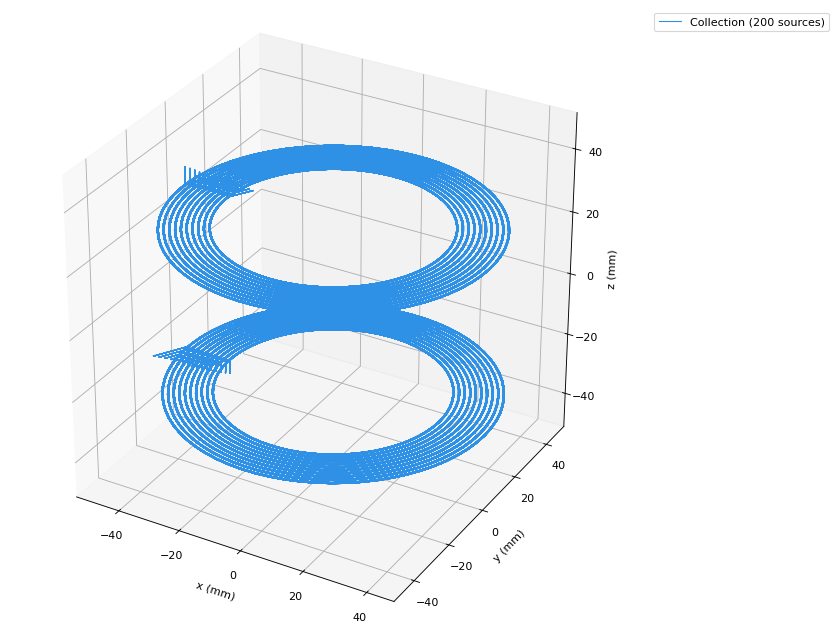

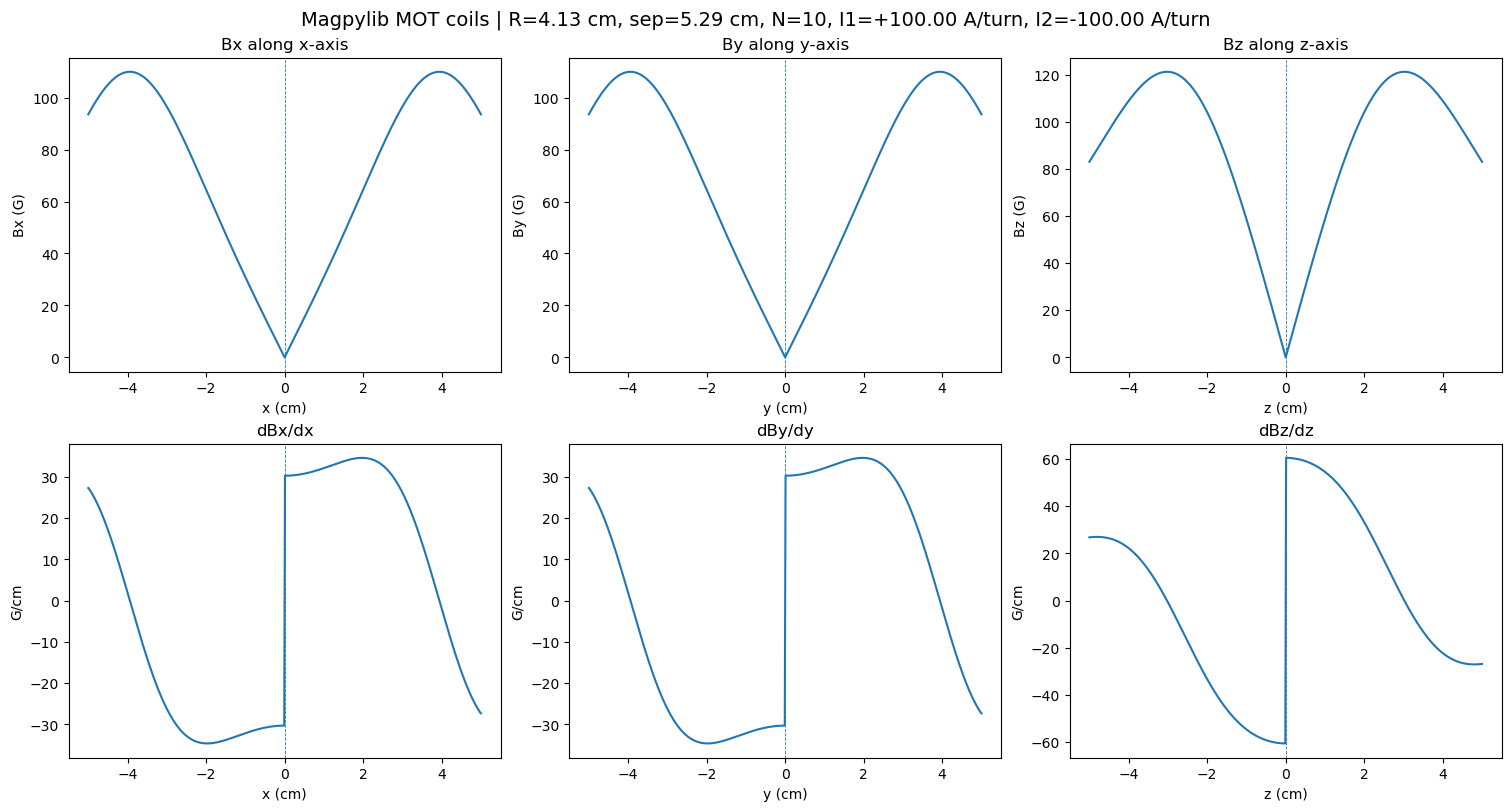

In [44]:
inch_to_m = 0.0254
# ---------------- USER INPUTS ----------------
radius = (0.06833 + 0.0969) / 2 / 2 #6 * inch_to_m           # radius (m)
radial_thickness = (0.0969 - 0.06833)/2 #1*inch_to_m  # radial coil thickness (m)
axial_thickness  = 0*inch_to_m  # axial coil thickness (m)
sep = 0.05293 #2.78 * inch_to_m            # coil separation (m)
Nturns = 10                        # turns per coil

# Independent per-turn currents (A). Sign sets current direction.
I1_per_turn = +100.0
I2_per_turn = -100.0

# Thickness discretization
Nr, Nz = 10, 10

# Axis plot ranges (m)
xmax = 0.05
ymax = 0.05
zmax = 0.05
npts = 1001

show_3d = True
# ----------------------------------------

# Build sources
sources = make_two_coils(
    radius, radial_thickness, axial_thickness, sep,
    Nturns, I1_per_turn, I2_per_turn,
    Nr=Nr, Nz=Nz
)

# 3D geometry plot
if show_3d:
    plot_geometry_3d(sources, radius, sep, I1_per_turn, I2_per_turn)

# Compute axis fields (Tesla)
(x, Bx_x), (y, By_y), (z, Bz_z) = compute_axis_fields(
    sources, xmax=xmax, ymax=ymax, zmax=zmax, npts=npts
)

# take absolute value of fields for gradient display (signs can be confusing)
Bx_x = np.abs(Bx_x)
By_y = np.abs(By_y)
Bz_z = np.abs(Bz_z)

# Gradients (T/m)
dBx_dx = np.gradient(Bx_x, x)
dBy_dy = np.gradient(By_y, y)
dBz_dz = np.gradient(Bz_z, z)

# Convert for display
x_cm = x * M_TO_CM
y_cm = y * M_TO_CM
z_cm = z * M_TO_CM

Bx_G = Bx_x * T_TO_G
By_G = By_y * T_TO_G
Bz_G = Bz_z * T_TO_G

dBx_dx_Gpcm = dBx_dx * T_PER_M_TO_G_PER_CM
dBy_dy_Gpcm = dBy_dy * T_PER_M_TO_G_PER_CM
dBz_dz_Gpcm = dBz_dz * T_PER_M_TO_G_PER_CM

# Plot: 2 rows x 3 columns
fig, ax = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)

ax[0,0].plot(x_cm, Bx_G); ax[0,0].axvline(0, ls="--", lw=0.6)
ax[0,0].set_title("Bx along x-axis"); ax[0,0].set_xlabel("x (cm)"); ax[0,0].set_ylabel("Bx (G)")

ax[0,1].plot(y_cm, By_G); ax[0,1].axvline(0, ls="--", lw=0.6)
ax[0,1].set_title("By along y-axis"); ax[0,1].set_xlabel("y (cm)"); ax[0,1].set_ylabel("By (G)")

ax[0,2].plot(z_cm, Bz_G); ax[0,2].axvline(0, ls="--", lw=0.6)
ax[0,2].set_title("Bz along z-axis"); ax[0,2].set_xlabel("z (cm)"); ax[0,2].set_ylabel("Bz (G)")

ax[1,0].plot(x_cm, dBx_dx_Gpcm); ax[1,0].axvline(0, ls="--", lw=0.6)
ax[1,0].set_title("dBx/dx"); ax[1,0].set_xlabel("x (cm)"); ax[1,0].set_ylabel("G/cm")

ax[1,1].plot(y_cm, dBy_dy_Gpcm); ax[1,1].axvline(0, ls="--", lw=0.6)
ax[1,1].set_title("dBy/dy"); ax[1,1].set_xlabel("y (cm)"); ax[1,1].set_ylabel("G/cm")

ax[1,2].plot(z_cm, dBz_dz_Gpcm); ax[1,2].axvline(0, ls="--", lw=0.6)
ax[1,2].set_title("dBz/dz"); ax[1,2].set_xlabel("z (cm)"); ax[1,2].set_ylabel("G/cm")

fig.suptitle(
    f"Magpylib MOT coils | R={radius*100:.2f} cm, sep={sep*100:.2f} cm, "
    f"N={Nturns}, I1={I1_per_turn:+.2f} A/turn, I2={I2_per_turn:+.2f} A/turn",
    fontsize=14
)
plt.show()



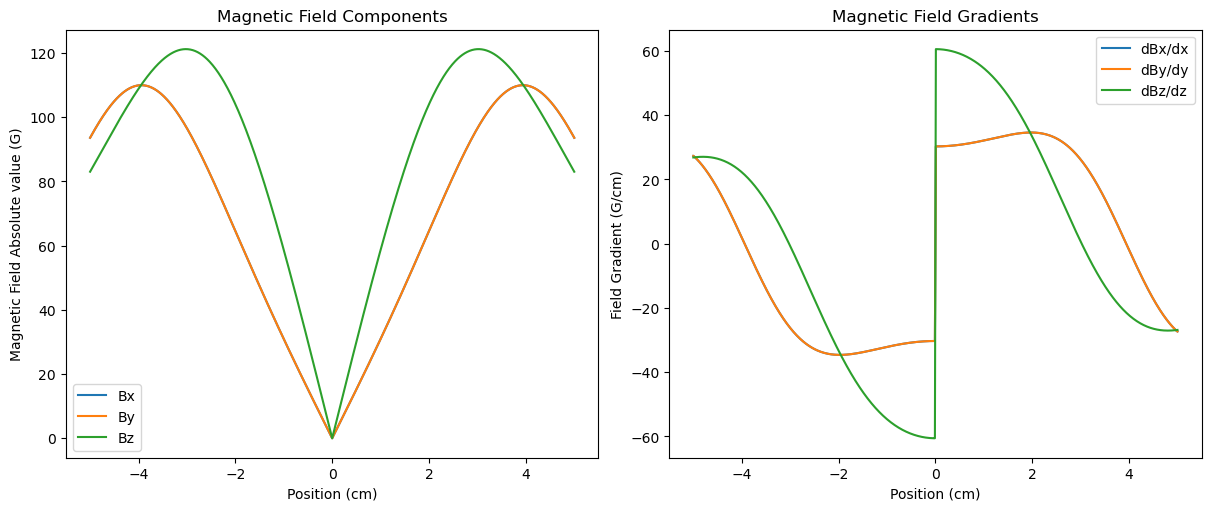

In [45]:
# make 2 plots, one with B components and one with gradients, to zoom in more on the gradient shapes
fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# B components
ax[0].plot(x_cm, Bx_G, label='Bx')
ax[0].plot(y_cm, By_G, label='By')
ax[0].plot(z_cm, Bz_G, label='Bz')
ax[0].set_xlabel("Position (cm)")
ax[0].set_ylabel("Magnetic Field Absolute value (G)")
ax[0].set_title("Magnetic Field Components")
ax[0].legend()

# Gradients
ax[1].plot(x_cm, dBx_dx_Gpcm, label='dBx/dx')
ax[1].plot(y_cm, dBy_dy_Gpcm, label='dBy/dy')
ax[1].plot(z_cm, dBz_dz_Gpcm, label='dBz/dz')
ax[1].set_xlabel("Position (cm)")
ax[1].set_ylabel("Field Gradient (G/cm)")
ax[1].set_title("Magnetic Field Gradients")
ax[1].legend()


